In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

prefix = 'results/'
suffix = '/599test_results_tps_iou01_person'

names = [
    'rcnn_sr07',
    'yolov3_sr07'
]

others = [
]

names = [n + suffix for n in names] + others

conf_threshold = 0.5
fig, ax = plt.subplots(2, 2, figsize=(17, 10))
leg = []
for name in names:
    save_dir = os.path.join(prefix + name + '.npz')
    if not os.path.exists(save_dir):
        print('Didn\'t find %s' % save_dir)
    else:
        thetas, info = np.load(save_dir, allow_pickle=True).values()
        confs_part = info[3] #[precision, recall, avg, confs_part]
        leg.append('%s ASR %.4f' % (name.split('/')[0], (confs_part<conf_threshold).mean()))
        ax[0, 0].plot(thetas, confs_part.mean(1))
        ax[0, 0].set_ylim(-0.05, 1.05)
        ax[0, 0].set_xlabel('viewing angles')
        ax[0, 0].set_ylabel('confidence')
        ax[0, 0].set_title('conf mean')
        ax[1, 0].plot(thetas, (confs_part < conf_threshold).mean(1))
        ax[1, 0].set_ylim(-0.05, 1.05) 
        ax[1, 0].set_xlabel('viewing angles')
        ax[1, 0].set_ylabel('success rate')
        ax[1, 0].set_title('detect threshold %.1f' % conf_threshold)
        ax[0, 1].scatter(np.tile(thetas[:, None], (1, confs_part.shape[1])), confs_part.flatten(), s=0.2)
        ax[0, 1].set_ylim(-0.05, 1.05)   
        ax[0, 1].set_title('conf scatter')
        ax[1, 1].plot(thetas, confs_part.max(1))
        ax[1, 1].set_ylim(-0.05, 1.05)    
        ax[1, 1].set_title('max conf')
ax[1, 0].legend(leg)
plt.show()


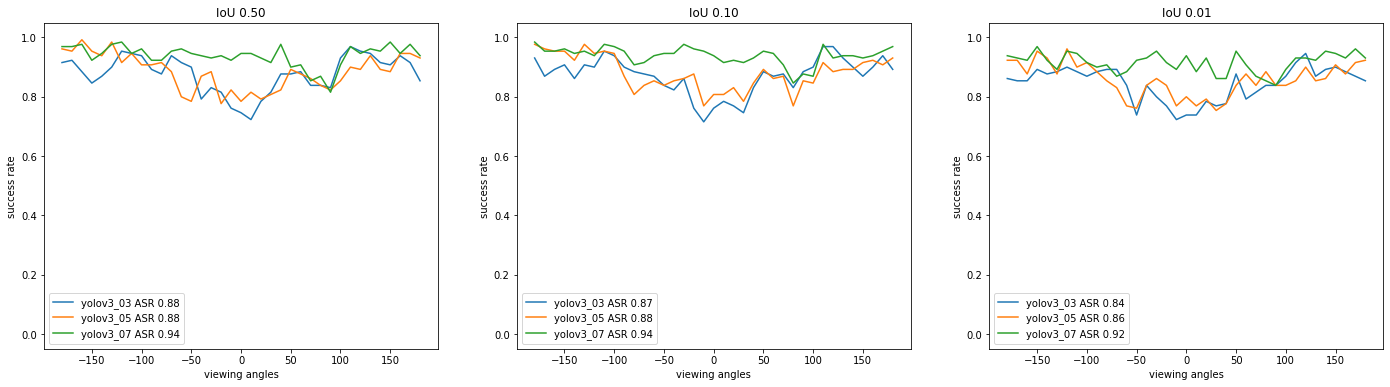

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt

prefix = 'results/'
suffixes = ['/599test_results_tps_iou05_person','/599test_results_tps_iou01_person','/599test_results_tps_iou001_person']
thres = [0.5,0.1,0.01]

name = [
    'yolov3_03',
    'yolov3_05',
    'yolov3_07'
]

others = [
]

namess = []
for i in range(3):
    names = [n + suffixes[i] for n in name] + others
    namess.append(names)

conf_threshold = 0.5
fig, ax = plt.subplots(1, 3, figsize=(24, 6))

for i in range(3):
    leg = []
    names = namess[i]
    for name in names:
        save_dir = os.path.join(prefix + name + '.npz')
        if not os.path.exists(save_dir):
            print('Didn\'t find %s' % save_dir)
        else:
            thetas, info = np.load(save_dir, allow_pickle=True).values()
            confs_part = info[3] #[precision, recall, avg, confs_part]
            leg.append('%s ASR %.2f' % (name.split('/')[0], (confs_part<conf_threshold).mean()))

            ax[i].plot(thetas, (confs_part < conf_threshold).mean(1))
            ax[i].set_title("IoU %.2f" % thres[i])
            ax[i].set_ylim(-0.05, 1.05) 
            ax[i].set_xlabel('viewing angles')
            ax[i].set_ylabel('success rate')
#             ax[i].set_title('detect threshold %.1f' % conf_threshold)
    ax[i].legend(leg)
# plt.legend()
plt.savefig('figures/yolov3_thres.png',bbox_inches='tight',dpi=200)
plt.show()


# Visualize Shirts

In [ ]:
from train import *


args = {
    'device': 'cuda:0',
    'lr': 0.001,
    'lr_seed':0.01,
    'nepoch':600,
    'checkpoints': 600,
    'save_path': 'results_final/rcnn_sr07',
    'batch_size':1,
    'alpha':10,
    'tv_loss':0,
    'lr_decay':2,
    'blur':1,
    'like':1,
    'ctrl':1,
    'num_points_tshirt':60,
    'num_points_trouser':60,
    'arch':'yolov3',
    'cdist':0,
    'seed_type':'variable',
    'rd_num':200,
    'clamp_shift':0.01,
    'seed_temp':1.0,
    'seed_opt':'adam',
    'seed_ratio':0.7,
    'loss_type':'max_iou',
    'test':True,
    'test_mode':'person',
    'train_iou':0.01,
    'tps3d_range':0.15,
    'anneal':False
}
args = EasyDict(args)

torch.manual_seed(123)
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False

trainer = PatchTrainer(args)
epoch = args.checkpoints - 1

tex,tex_trouser = trainer.update_mesh(type='determinate')
tex_img = Image.fromarray(np.array(255*tex.squeeze(0).detach().cpu()).astype('uint8'))
tex_img.show()

img_batch = torch.ones(1,3,416,416).to(args.device)




# # Visualize Whole Scene:
# trainer.sample_lights(r=0.1
# with torch.no_grad():
#     j = 0
#     for i_batch, img_batch in enumerate(trainer.test_loader):
#         img_batch = img_batch.to(args.device)
#         trainer.sample_cameras(theta=15)
#         torch.manual_seed(124)
#         p_img_batch, gt = trainer.synthesis_image(img_batch, False,False)
#         if i_batch == 12:
#             break
# plt.figure(figsize=(10,10))

# imgs = Image.fromarray(np.array(255*p_img_batch.squeeze(0).permute(1,2,0).detach().cpu()).astype('uint8'))
# plt.imshow(imgs)
# imgs.save("tex/syn_img.png")



# Visualize human:

thetas = [30,210]
imgs = []
for theta in thetas:
    trainer.sample_cameras(theta,1)
    trainer.sample_lights(r=0)
    p_img_batch, gt = trainer.synthesis_image(img_batch,False,False)

    p_img_batch = p_img_batch[:,:,gt[0][1]:gt[0][3],gt[0][0]:gt[0][2]]
    imgs.append(Image.fromarray(np.array(255*p_img_batch.squeeze(0)\
                                         .permute(1,2,0).detach().cpu()).astype('uint8')))
fig, ax = plt.subplots(1, len(thetas), figsize=(3*len(thetas), 8))
for i in range(len(imgs)):
    ax[i].imshow(imgs[i])
    ax[i].axis('off')
path = args.save_path.split('/')[1]
# path = args.arch+'_'+ str(args.seed_ratio).replace('.', '')
# plt.savefig('figures/'+path,dpi=400)
plt.show()


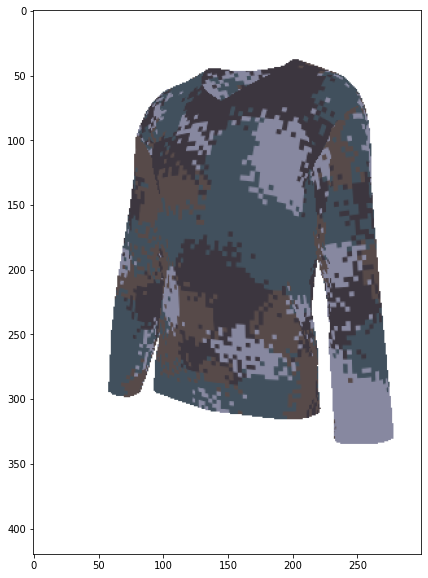

In [60]:
import PIL
from PIL import Image
import load_data
from tqdm import tqdm

from load_data import *
import gc
import matplotlib.pyplot as plt
from torch import autograd
from torchvision import transforms
import torchvision
from tensorboardX import SummaryWriter
import subprocess

#import patch_config
import sys
import time
from datetime import datetime
import argparse
from torch.autograd import Variable, Function
import itertools
import os
import torch

from pytorch3d.utils import ico_sphere
import numpy as np

device="cuda:9"
meshes = trainer.mesh_tshirt
# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, save_obj, load_obj

from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)

# Data structures and functions for rendering
from pytorch3d.structures import Meshes, join_meshes_as_batch, join_meshes_as_scene
from pytorch3d.vis.plotly_vis import plot_scene
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    SoftSilhouetteShader,
    SoftPhongShader,
    TexturesVertex,
    TexturesAtlas,
    BlendParams,
    TexturesUV
)
lights = AmbientLights(device=device,ambient_color=(0.9,0.9,0.9))
# lights = DirectionalLights(device=device,direction=[[0.0,1.0,1.0]])
azim = torch.tensor([30])
R, T = look_at_view_transform(dist=1, azim=azim,elev=15)
cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)

raster_settings = RasterizationSettings(
    image_size=512, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
)

renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device, 
        cameras=cameras,
        lights=lights
    )
)
# meshes.offset_verts_(torch.tensor([0,0,0]).to(device))
# meshes.scale_verts_(0.5)
unloader = transforms.ToPILImage()
target_img =renderer(meshes)
# lights.direction = [[0.0,0.0,-1]]

plt.figure(figsize=(10,10))
# for i in range(9):
#     plt.subplot(331+i)
#     if 3 <= i <= 6:
plt.imshow(target_img[0].detach().cpu()[0:420, 100:400,0:3])
#     else:
#         plt.imshow(target_img[i].detach().cpu()[0:420, 100:400,0:3])
#     plt.legend('1')
#     plt.text(160,380, r"$ \mathrm{azim}=$"+str(i*45)+r"$^\circ$", size=28)
plt.savefig("tex/random_vi")
plt.show()

torch.Size([1, 340, 864, 3])


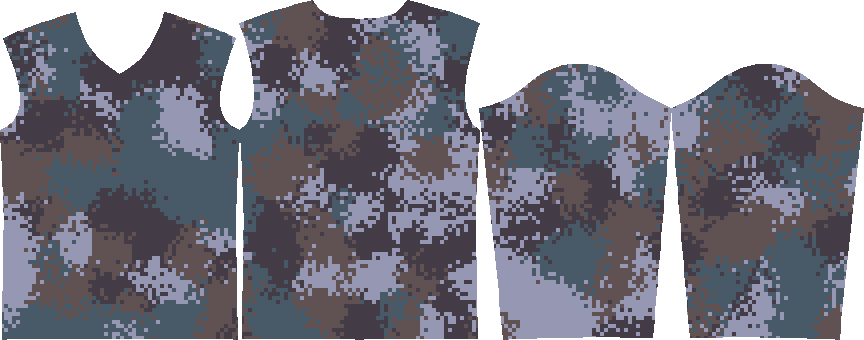

In [59]:
import torch
import cv2
import numpy as np


def compute_map_mask(mesh, border=0):
    mesh = mesh.clone().detach()
    x = mesh.textures.verts_uvs_padded()[0, :, 0].cpu().numpy()
    y = mesh.textures.verts_uvs_padded()[0, :, 1].cpu().numpy()
    m = torch.zeros_like(mesh.textures._maps_padded[0, :, :, 0]).cpu().numpy()
    faces = mesh.textures.faces_uvs_padded()[0].clone().cpu().numpy()

    xt = x * (m.shape[1] - 1)
    yt = (1 - y) * (m.shape[0] - 1)
    xt, yt = xt.astype(np.int64), yt.astype(np.int64)
    tri_coords = []
    for f in faces:
        tri_coords.append([[xt[i], yt[i]] for i in f])
    tri_coords = np.array(tri_coords)
    # cv2.drawContours(m, [t for t in tri_coords], -1, (1.0, 1.0, 1.0), -1)
    cv2.drawContours(m, [t for t in tri_coords], -1, 1.0, -1)
    if border > 0:
        cv2.drawContours(m, [t for t in tri_coords], -1, 1.0, border)

    mask = torch.from_numpy(m).unsqueeze(0).unsqueeze(-1).to(mesh.textures._maps_padded)
    return mask

mesh = trainer.mesh_tshirt
mask = compute_map_mask(mesh,1)
maps = mesh.textures._maps_padded*mask + (1-mask)
print(maps.shape)
tex_img = Image.fromarray(np.array(255*maps.squeeze(0).detach().cpu()).astype('uint8'))
tex_img.save("tex/map.png")
tex_img.show()
# maps = maps.repeat_interleave(expands, 1).repeat_interleave(expands,2)
# imshow(maps,img_type='NWHC')

# Visualize Voronoi Diagram

torch.Size([5, 512, 512])
torch.Size([512, 512, 3])


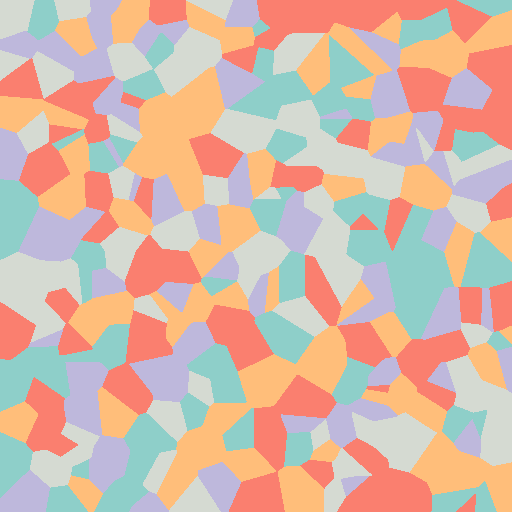

In [39]:
import torch
from generator import *
from PIL import Image
import matplotlib.pyplot as plt
h,w = 512,512
device = 'cuda:0'
# circles = torch.rand([5,60,3]).to(device)

colors = torch.tensor([
    [142.0,207,201],[255,190,122],[250,127,111],[213,218,210],[190,184,220]
])
colors = colors.to(device)
colors /= 255

coordinates = torch.zeros([h,w,2]).to(device)
for i in range(h):
    coordinates[i,:,0] = i
for j in range(w):
    coordinates[:,j,1] = j
    
prob_map = prob_fix_color(circles,coordinates,colors,h,w,0.5)
print(prob_map.shape)

# Approximate:
# color_map = torch.matmul(prob_map.permute(1,2,0), colors)
# print(color_map.shape)

# Accurate:
cmap = torch.argmax(prob_map,dim=0).expand(3,512,512).permute(1,2,0)
print(cmap.shape)
color_map = colors[0]*(cmap == 0) + colors[1]*(cmap==1) + colors[2] *(cmap == 2) + \
colors[3]*(cmap==3) + colors[4] *(cmap == 4)


img_tex = Image.fromarray(np.array((color_map*255).detach().cpu()).astype("uint8")).convert("RGB")
img_tex.save("figures/real_voronoi.png")
img_tex.show()
